# Stock Clustering - Finding High Returns, Low Volatility stocks

In [123]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas_datareader as dr
import pickle

# Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, ward
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from sklearn import metrics

from statsmodels.tsa.stattools import coint

# Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

import yahoo_fin.stock_info as si
import yfinance as yf

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-10-16 15:31:24 +08:00)


## Load data

In [2]:
# The dataset was saved in the previous notebook. Price data taken from 2015 to 2019.
dataset = pickle.load(open('./data/01_pricedate_2015_2019.pkl', 'rb'))

time: 15 ms (started: 2022-10-16 14:55:17 +08:00)


In [3]:
# Shape of dataset
dataset.shape

(1256, 487)

time: 0 ns (started: 2022-10-16 14:55:17 +08:00)


In [4]:
# Peek at data
set_option('display.width', 100)
dataset.head(5)

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,37.420185,51.051483,151.336792,24.120045,46.710945,79.661964,37.070000,39.125034,76.426567,71.980003,...,127.430626,29.178459,64.219269,49.259911,32.530121,44.445164,107.125671,76.339996,24.042185,41.035954
2015-01-06,36.837265,50.255585,151.230377,24.122320,46.479752,80.097168,36.130001,38.680729,75.875282,70.529999,...,124.712402,29.333715,63.877869,48.648579,32.338821,43.899632,106.217575,75.790001,23.123941,40.635601
2015-01-07,37.326168,50.227158,154.480148,24.460564,48.358299,81.695938,37.279999,38.994354,77.467850,71.110001,...,128.374954,29.587006,64.525108,49.909447,32.593887,45.354382,108.859299,77.720001,23.344675,41.474419
2015-01-08,38.445004,50.843037,155.834167,25.400398,48.864059,81.882439,38.959999,39.795853,78.649185,72.919998,...,129.919449,29.930189,65.599113,51.141659,32.839859,46.144466,110.015007,79.379997,23.671360,42.113091
2015-01-09,38.162949,49.289127,155.041122,25.427635,47.527401,82.601891,38.410000,39.377686,78.561676,71.839996,...,131.543274,29.562494,65.506653,50.396595,32.220402,46.062954,108.428177,80.540001,23.009155,42.179813


time: 15 ms (started: 2022-10-16 14:55:17 +08:00)


In [5]:
# describe data
set_option('precision', 3)
dataset.describe()

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,...,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000,1256.000
mean,55.006,39.638,143.622,36.906,59.805,82.091,182.990,52.047,127.330,167.241,...,111.760,40.805,62.954,53.025,54.490,70.015,109.944,122.043,36.427,68.409
std,14.512,7.182,23.422,11.335,14.624,8.115,107.157,15.550,33.608,79.427,...,30.902,9.438,3.668,7.393,16.691,18.610,11.452,53.268,9.894,25.690
min,31.622,24.281,77.127,21.099,36.022,62.801,36.130,32.535,73.530,69.990,...,46.518,26.588,50.110,33.568,27.965,42.096,84.815,46.930,17.704,37.846
25%,39.922,33.877,136.224,26.777,47.497,76.607,97.265,39.348,100.986,93.993,...,89.535,34.143,60.485,49.051,38.141,55.215,103.562,80.683,25.753,46.105
50%,57.711,39.597,149.835,36.048,56.181,81.444,142.980,45.068,117.823,143.605,...,111.691,39.919,63.094,54.760,51.807,68.095,109.340,105.910,38.932,60.530
75%,66.881,45.370,158.723,45.070,73.447,85.989,265.538,64.727,152.798,249.120,...,131.382,45.372,65.577,58.498,71.192,82.795,116.975,163.580,45.054,86.562
max,84.129,56.989,194.023,72.026,99.695,102.871,449.750,85.388,205.783,331.200,...,190.356,62.595,71.204,66.581,82.366,114.009,144.435,258.280,53.566,131.554


time: 500 ms (started: 2022-10-16 14:55:17 +08:00)


## Feature Engineering

For clustering and with no other information other than the price data, we can use the annual
returns and volatility as variables. These are indicators of the stock performance, and would give us a good idea if our algorithm can sort clusters based on these two variables.

In [6]:
# Calculate average annual percentage return and volatilities over a one year period.

returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)

returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)

data = returns

time: 31 ms (started: 2022-10-16 14:55:18 +08:00)


In [7]:
# Getting the mean returns and volatility of each stock
data.head()

,Returns,Volatility
Symbol,,
A,0.189,0.231
AAL,-0.055,0.358
AAP,0.055,0.316
AAPL,0.251,0.248
ABBV,0.147,0.284


time: 0 ns (started: 2022-10-16 14:55:18 +08:00)


In [8]:
# Use StandardScaler to standardize the two features
ss = StandardScaler()
data_sc = pd.DataFrame(ss.fit_transform(data),
                       columns = data.columns, index = data.index)

time: 0 ns (started: 2022-10-16 14:55:18 +08:00)


In [9]:
# Summarize scaled data
# Index are the stocks and the variables we want to cluster on are the columns
X = data_sc
X.head(2)

,Returns,Volatility
Symbol,,
A,0.342,-0.318
AAL,-1.930,1.241


time: 0 ns (started: 2022-10-16 14:55:18 +08:00)


## Modelling
1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation 

## Model 1: K-Means Clustering


We have to determine the number of clusters using this algorithm. We do this in two ways:
1. Elbow method: Based on the sum of square errors (SSE) within clusters
2. Silhouette score

### Using Elbow method to determine number of clusters

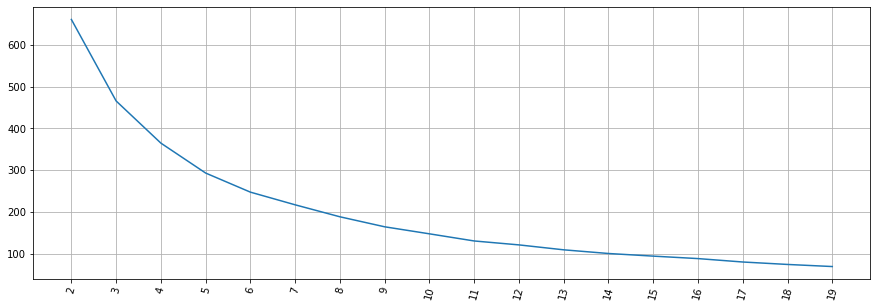

time: 6.3 s (started: 2022-10-16 14:59:06 +08:00)


In [42]:
# Create an empty list to store values
distorsions = []

# Define the max number of clusters to run
max_loop=20

for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True);

Inspecting the sum of squared errors chart, it appears the elbow occurs at about 3-4
clusters. As the number of clusters increase pass 10, the sum of square of errors within clusters plateaus off.

### Using Silhouette score to determine number of clusters

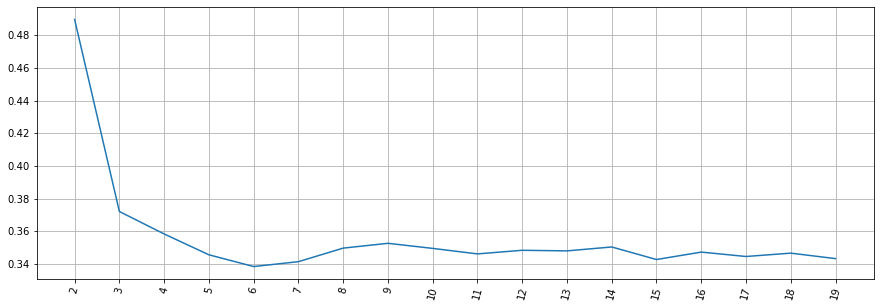

time: 6.33 s (started: 2022-10-16 15:05:15 +08:00)


In [46]:
# Create empty list to store the Silhouette Scores for different number of clusters
list_of_silscores = []

# Run the same number of max clusters as in previous Elbow method
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
    kmeans.fit(X)        
    list_of_silscores.append(metrics.silhouette_score(X, kmeans.labels_, random_state=42))
    
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), list_of_silscores)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid();

From the chart, we can see that there is a a sharp bend at cluster=3.

In [48]:
# Fit K-means with 3 clusters
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)

KMeans(n_clusters=3)

time: 297 ms (started: 2022-10-16 15:07:16 +08:00)


In [105]:
# Finding the target cluster label for each stock
target_labels = k_means.predict(X)

time: 32 ms (started: 2022-10-16 15:21:37 +08:00)


Since we only have two variables in the data, it is easy to visualize the clusters in a 2d space. If we include more variables in the future, it will be harder to visualize.

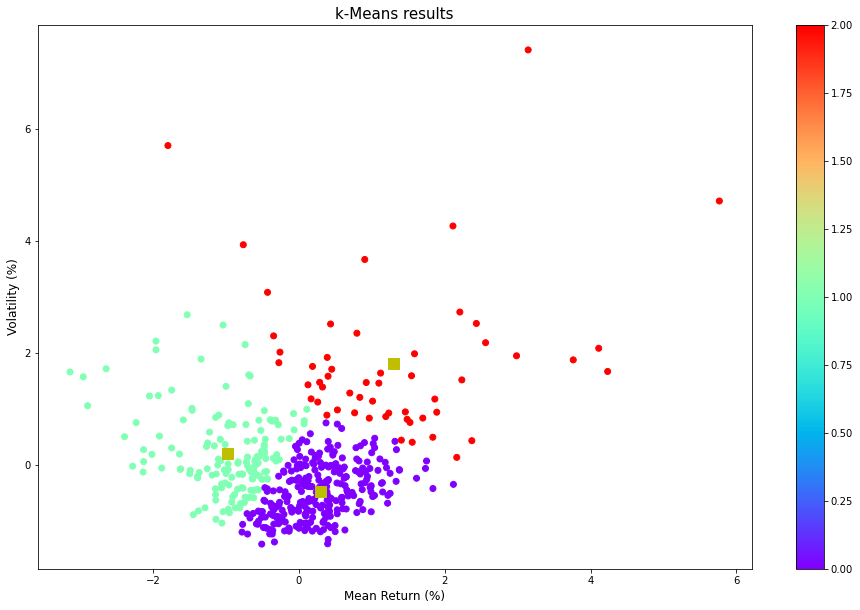

time: 172 ms (started: 2022-10-16 15:43:22 +08:00)


In [135]:
# Define location of the cluster centers
centroids = k_means.cluster_centers_

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1)

# Plot return against volatility
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1],
                     c = target_labels, cmap='rainbow',
                     label = X.index)

ax.set_title('k-Means results', fontsize=15)
ax.set_xlabel('Mean Return (%)', fontsize=12)
ax.set_ylabel('Volatility (%)', fontsize=12)
plt.colorbar(scatter)

# Plot the positions of the centroids
plt.plot(centroids[:,0], centroids[:,1], 'ys', markersize=11);

0    280
1    153
2     54
dtype: int64


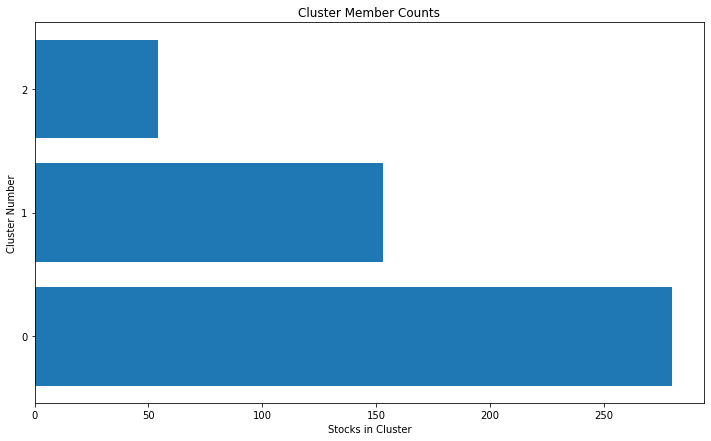

time: 219 ms (started: 2022-10-16 15:29:52 +08:00)


In [122]:
# Show number of stocks in each cluster
# cluster shows stocks with its corresponding cluster
cluster = pd.Series(index=X.index, data=target_labels.flatten())
print(cluster.value_counts())

plt.figure(figsize=(12,7))
plt.barh(range(len(cluster.value_counts())), cluster.value_counts())

plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.yticks([2,1,0])
plt.show()

The smallest cluster has 54 stocks while the largest has 280 stocks.

## Model 2: Hierarchical Clustering (Agglomerative Clustering)

The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters. We want to look at the hierarchy graph and check for the number of clusters.

In [126]:
# Calculate linkage
Z = linkage(X, method='ward')

time: 15 ms (started: 2022-10-16 15:32:58 +08:00)


The best way to visualize is through a dendrogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis. The longer the branches are, the less correlated (different) two clusters are.

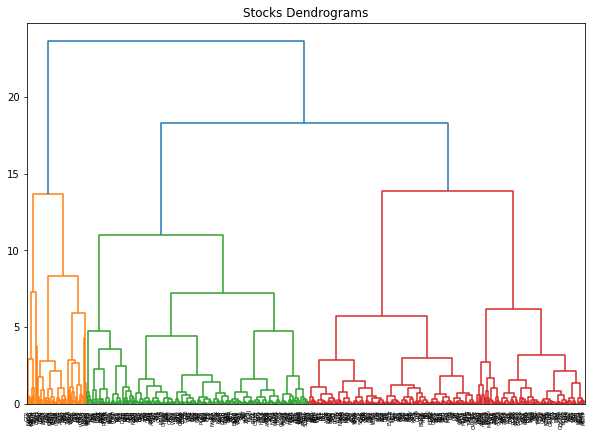

time: 4.95 s (started: 2022-10-16 15:34:26 +08:00)


In [127]:
# Plot dendrogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")

# Labels may be too small to see, but not important at this stage
dendrogram(Z, labels = X.index)
plt.show();

- Once a big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. 
- The number of vertical lines this newly created horizontal line passes is equal to number of clusters.
- We select a distance threshold to cut the dendrogram to obtain the selected clustering level. The output is the cluster labelled for each row of data. If we cut at 15, we get 3 clusters.

In [131]:
distance_threshold = 15
clusters = fcluster(Z, distance_threshold, criterion='distance')

# Stores the cluster number for each stock
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([3, 2, 1])

time: 0 ns (started: 2022-10-16 15:39:00 +08:00)


In [130]:
chosen_clusters

,cluster
0,3
1,2
2,2
3,3
4,2
...,...
482,3
483,2
484,1
485,2


time: 16 ms (started: 2022-10-16 15:37:55 +08:00)


In [132]:
# Build the hierarchical clustering with 3 clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
target_labels_hc = hc.fit_predict(X)

time: 0 ns (started: 2022-10-16 15:41:32 +08:00)


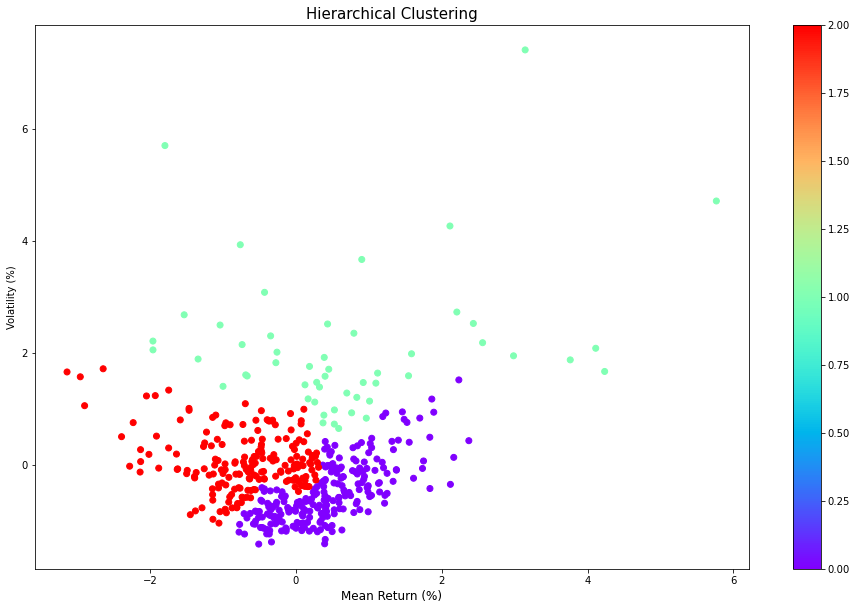

time: 156 ms (started: 2022-10-16 15:42:48 +08:00)


In [134]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

# Similarly plot returns against volatility
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1],
                     c =target_labels_hc, cmap ="rainbow")

ax.set_title('Hierarchical Clustering', fontsize=15)
ax.set_xlabel('Mean Return (%)', fontsize=12)
ax.set_ylabel('Volatility (%)')
plt.colorbar(scatter)

# Model 3: Affinity Propagation

Creates clusters by sending messages between data points until convergence. It does not require number of clusters to be determined or estimated.

In [136]:
# Instantiate algorithm
ap = AffinityPropagation()
ap.fit(X)

# Get target labels
target_labels_ap = ap.predict(X)

time: 469 ms (started: 2022-10-16 15:45:06 +08:00)


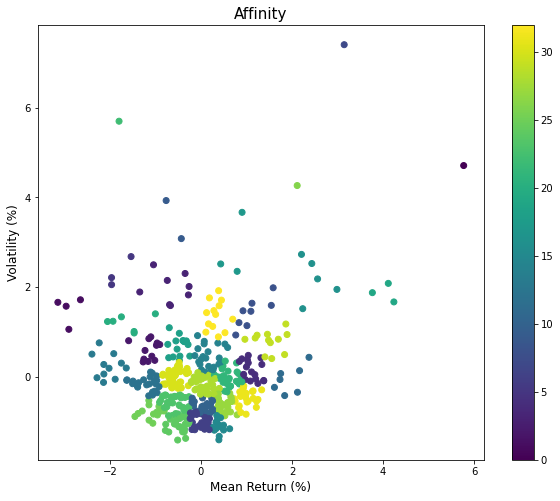

time: 125 ms (started: 2022-10-16 15:47:21 +08:00)


In [138]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], 
                     c=target_labels_ap, cmap ="viridis")

ax.set_title('Affinity', fontsize=15)
ax.set_xlabel('Mean Return (%)', fontsize=12)
ax.set_ylabel('Volatility (%)', fontsize=12)
plt.colorbar(scatter)

While we can see a separation, there looks to be too many different clusters to do a proper analysis. 

In [139]:
# Specify the cluster centers
cluster_centers_indices = ap.cluster_centers_indices_

time: 0 ns (started: 2022-10-16 15:49:58 +08:00)


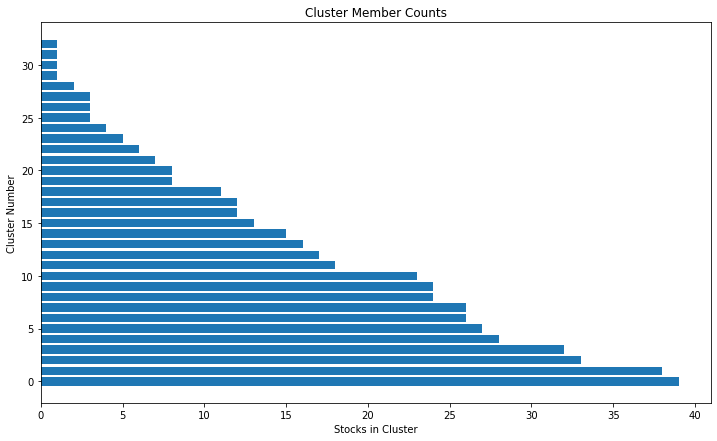

time: 125 ms (started: 2022-10-16 15:51:48 +08:00)


In [140]:
# Show number of stocks in each cluster
# cluster shows stocks with its corresponding cluster
cluster_ap = pd.Series(index=X.index, data=target_labels_ap.flatten())

plt.figure(figsize=(12,7))
plt.barh(range(len(cluster_ap.value_counts())), cluster_ap.value_counts())

plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

# Evaluation of the 3 models

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

In [144]:
print("km", metrics.silhouette_score(X, target_labels, metric='euclidean'))
print("hc", metrics.silhouette_score(X, target_labels_hc, metric='euclidean'))
print("ap", metrics.silhouette_score(X, target_labels_ap, metric='euclidean'))

km 0.37188428735129053
hc 0.2834646684483551
ap 0.32830087184322787
time: 15 ms (started: 2022-10-16 15:57:56 +08:00)


K-means provides the best silhouette score, so we will go with the K-means algorithm and do further visualisation.

### Visualising stock returns within a cluster

The understand the intuition behind clustering, let us visualize the results of the clusters.

In [150]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=target_labels.flatten())
# # clustered stock with its cluster label
# clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
# clustered_series = clustered_series[clustered_series != -1]

time: 0 ns (started: 2022-10-16 16:03:12 +08:00)


In [151]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[]

time: 0 ns (started: 2022-10-16 16:03:25 +08:00)


In [147]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 29
Pairs to evaluate: 11098
time: 0 ns (started: 2022-10-16 15:59:30 +08:00)


In [148]:
# plot a handful of the smallest clusters
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[9, 17, 19, 5]

<Figure size 864x504 with 0 Axes>

time: 0 ns (started: 2022-10-16 15:59:31 +08:00)


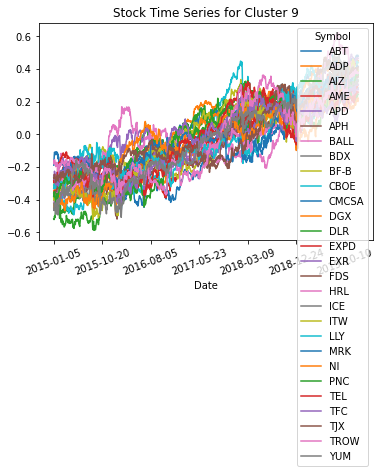

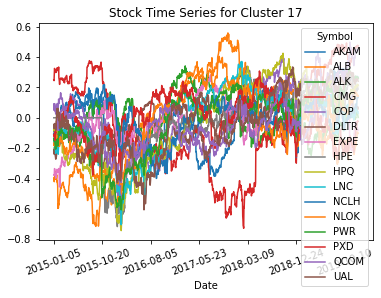

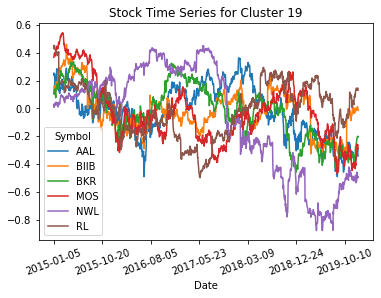

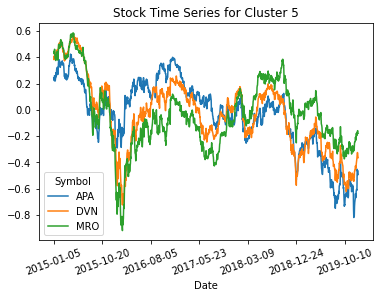

time: 781 ms (started: 2022-10-16 15:59:33 +08:00)


In [149]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:"2019-12-31", tickers].mean())
    data = np.log(dataset.loc[:"2019-12-31", tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
    plt.xticks(rotation=20)
plt.show()

Looking at the charts above, across all the clusters with small number of stocks, we
see similar movement of the stocks under different clusters, which corroborates the
effectiveness of the clustering technique.

<a id='6'></a>
# 6. Pairs Selection

<a id='6.1'></a>
## 6.1. Cointegration and Pair Selection Function

We set the significance at 0.05, so if p-value is less than 0.05, we reject the null hypothesis that there is no cointegration. 

In [33]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

time: 0 ns (started: 2022-10-16 14:55:39 +08:00)


In [34]:

cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

time: 10.6 s (started: 2022-10-16 14:55:39 +08:00)


In [35]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

time: 0 ns (started: 2022-10-16 14:55:50 +08:00)


In [36]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 47
In those pairs, there are 62 unique tickers.
time: 0 ns (started: 2022-10-16 14:55:50 +08:00)


In [37]:
pairs

[('A', 'WAT'),
 ('AXP', 'ORCL'),
 ('ADI', 'CRL'),
 ('ADI', 'DE'),
 ('ADI', 'DRI'),
 ('ADI', 'GRMN'),
 ('ADI', 'LYV'),
 ('ADI', 'ODFL'),
 ('ABT', 'FDS'),
 ('AEE', 'AFL'),
 ('AEE', 'CCI'),
 ('AEE', 'CPT'),
 ('AEE', 'DTE'),
 ('AEE', 'MMC'),
 ('AEE', 'PAYX'),
 ('AEE', 'UDR'),
 ('AVB', 'D'),
 ('AVB', 'ETR'),
 ('AVB', 'KO'),
 ('AVB', 'PEP'),
 ('AVB', 'PG'),
 ('AVB', 'SO'),
 ('AVB', 'SRE'),
 ('ACN', 'FIS'),
 ('ACN', 'NDAQ'),
 ('ACN', 'SYK'),
 ('ACN', 'TMO'),
 ('ABBV', 'CAT'),
 ('ABBV', 'LVS'),
 ('ABBV', 'LYB'),
 ('ABBV', 'RF'),
 ('ABBV', 'SCHW'),
 ('ANSS', 'CTAS'),
 ('ANSS', 'EL'),
 ('ANSS', 'LHX'),
 ('ANSS', 'SPGI'),
 ('ANSS', 'TDY'),
 ('ANSS', 'ZTS'),
 ('ABC', 'GILD'),
 ('ABC', 'NWSA'),
 ('AJG', 'HD'),
 ('AJG', 'NEE'),
 ('AIG', 'SPG'),
 ('DXC', 'FANG'),
 ('ADSK', 'AVGO'),
 ('ADSK', 'MPWR'),
 ('AAP', 'WBD')]

time: 0 ns (started: 2022-10-16 14:55:50 +08:00)


<a id='6.2'></a>
## 6.2. Pair Visualization

In [38]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

time: 0 ns (started: 2022-10-16 14:55:50 +08:00)


In [39]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

time: 0 ns (started: 2022-10-16 14:55:50 +08:00)


In [40]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

time: 204 ms (started: 2022-10-16 14:55:50 +08:00)


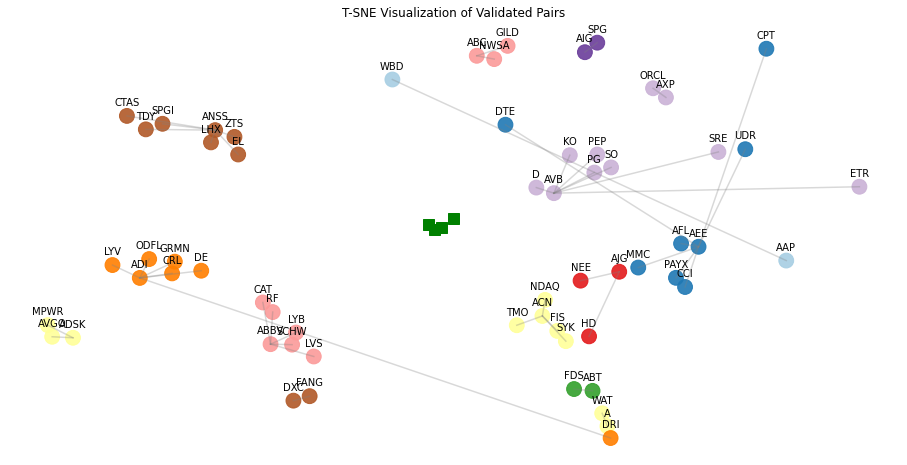

time: 297 ms (started: 2022-10-16 14:55:50 +08:00)


In [41]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs'); 

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


**Conclusion**

The clustering techniques do not directly help in stock trend prediction. However,
they can be effectively used in portfolio construction for finding the right pairs,
which eventually help in risk mitigation and one can achieve superior risk adjusted
returns.

We showed the approaches to finding the appropriate number of clusters in k-means
and built a hierarchy graph in hierarchical clustering. A next step from this case study
would be to explore and backtest various long/short trading strategies with pairs of
stocks from the groupings of stocks.

Clustering can effectively be used for dividing stocks into groups with “similar characteristics” for many other kinds of trading strategies and can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification
between them.